# Natural Language Processing (NLP)

##  Data Pre-processing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
from textblob import Word
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer      
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
#load text and pre-process before finding words to remove

path = "input.txt"
with open(path, "r") as file:    
    txt = file.read()     
tokens = nltk.sent_tokenize(txt)                                   #tokenize into sentences
tokens[:10]

[' \nOctober 2015 \n\n \n\n\nNational Economic Council  \nand  \nOffice of Science and Technology Policy \n \n\n\nA STRATEGY FOR AMERICAN INNOVATION \n\n \nNational Economic Council and Office of Science and Technology Policy \n \n   \nEmpowering a Nation of Innovators \n\n\nÒThis is a country that imagined a railroad connecting a continent, imagined electricity powering our cities and towns, imagined skyscrapers reaching into the heavens, and an Internet that brings us closer together.',
 'So we imagined these things, then we did them.',
 'And thatÕs in our DNA.',
 'ThatÕs who we are.',
 'WeÕre not done yet.Ó \n\n-President Barack Obama, Remarks at the White House Maker Faire, National Day ofMaking, June 18, 2014\n\n\n\n\n\n\n\n\nPresident ObamaÕs Administration has taken more steps than any prior Administration to involve new communities in the innovation process and empower a broad range of innovators to help solve the nationÕs pressing challenges.',
 'The Administration has done th

There are numerous linebreaks at unusual places. Based on observation, splitting lines where there are 2 or more linebreaks would result in more meaningful sentences. There is a need to remove empty strings and bullet points. 
 

In [3]:
tokens = [re.split(r'([\n][ ]*?[\n]){1,}',t) for t in tokens]      #split lines if there are 2 or more linebreaks
tokens = [item for sublist in tokens for item in sublist]          #flatten nested list
tokens = [' '.join(x.split()) for x in tokens]                     #remove remaining linebreaks in sentences
tokens = [x for x in tokens if len(x)>1]                           #remove empty strings and bullet points
tokens[:10]

['October 2015',
 'National Economic Council and Office of Science and Technology Policy',
 'A STRATEGY FOR AMERICAN INNOVATION',
 'National Economic Council and Office of Science and Technology Policy',
 'Empowering a Nation of Innovators',
 'ÒThis is a country that imagined a railroad connecting a continent, imagined electricity powering our cities and towns, imagined skyscrapers reaching into the heavens, and an Internet that brings us closer together.',
 'So we imagined these things, then we did them.',
 'And thatÕs in our DNA.',
 'ThatÕs who we are.',
 'WeÕre not done yet.Ó']

Further pre-processing of text is required: 
- As there are a number of words with punctuations, will process them accordingly to minimise losing them. 
- It is observed that all ' character in the text is shown as Õ, which we will replace with a space. 
- There are a number of non-ascii characters (eg. ÒÓÐÑñõÕ) and numbers, both of which will be removed from text.  
- Punctuations will be removed 
- Words converted to lowercase
- Words would be lemmatized

In [4]:
tokens = [re.sub(r'U.S.',"United States",x) for x in tokens]             #replace short form with full form since could potentially be an important term given context of text
tokens = [re.sub(r'R&D',"research and development",x) for x in tokens]   #replace short form with full form since could potentially be an important term given context of text
tokens = [re.sub(r'[Õ]',"'",x) for x in tokens]                        #replace Õ with '  
tokens = [re.sub(r'[ÒÓÐÑñõÕ]',"",x) for x in tokens]                   #remove all the non-ascii characters and numbers
df = pd.DataFrame(tokens, columns=["original"])                        #create dataframe of original sentences
df

,original
0,October 2015
1,National Economic Council and Office of Scienc...
2,A STRATEGY FOR AMERICAN INNOVATION
3,National Economic Council and Office of Scienc...
4,Empowering a Nation of Innovators
...,...
515,Make better use of existing data while protect...
516,"In the 2016 Budget, the Administration called ..."
517,"For example, most Federal agencies cannot acce..."
518,Create an incentive fund for Pay for Success a...


In [5]:
df['sentence'] = df['original'].apply(lambda x: " ".join(x.lower() for x in x.split()))  #convert to lowercase
df['sentence'] = df['sentence'].str.replace("[']",' ')                     #replace ' with whitespace
df['sentence'] = df['sentence'].str.replace("[-.]",' ')                    #replace dot and hyphen with whitespace  
df['sentence'] = df['sentence'].str.replace('[^\w\s]|\d+','')              #remove punctuations
df["sentence"] = df["sentence"].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))   #lemmatize words
df

,original,sentence
0,October 2015,october
1,National Economic Council and Office of Scienc...,national economic council and office of scienc...
2,A STRATEGY FOR AMERICAN INNOVATION,a strategy for american innovation
3,National Economic Council and Office of Scienc...,national economic council and office of scienc...
4,Empowering a Nation of Innovators,empowering a nation of innovator
...,...,...
515,Make better use of existing data while protect...,make better use of existing data while protect...
516,"In the 2016 Budget, the Administration called ...",in the budget the administration called on con...
517,"For example, most Federal agencies cannot acce...",for example most federal agency cannot access ...
518,Create an incentive fund for Pay for Success a...,create an incentive fund for pay for success a...


### Top 100 Stop Words

Having pre-processed the text, we will find the top 100 stop words present in the text, ranked by number of occurrences. 

In [6]:
stop = stopwords.words('english')
df["stop"] = df["sentence"].apply(lambda x: ' '.join([x for x in x.split() if x in stop]))  #create list of stop words for each sentence
stopfreq = pd.Series(' '.join(df['stop']).split()).value_counts()[:100]     #list of stop words
stopfreq = stopfreq.to_frame().reset_index()                                #store stop words in dataframe
stopfreq = stopfreq.rename(columns= {'index': 'word', 0:'count'})
stopfreq.index.name = 'index'
stopfreq

,word,count
index,,
0,the,668
1,and,574
2,to,435
3,of,385
4,a,233
...,...,...
95,before,1
96,he,1
97,then,1


### Top 100 Common and Rare Words

Next, we will find the frequency of all the words present in the text and extract the top 100 common words and rare words. 

In [7]:
prefreq = pd.Series(' '.join(df['sentence']).split()).value_counts()           #count of all words
prefreq = prefreq.to_frame().reset_index()
prefreq = prefreq.rename(columns= {'index': 'word', 0:'count'}).sort_values(by='count', ascending=False)
prefreq.index.name = 'index'

common = prefreq[:100].reset_index().drop(['index'],axis=1)     #list of top 100 common words
common.index.name = 'index'
common

,word,count
index,,
0,the,668
1,and,574
2,to,435
3,of,385
4,a,233
...,...,...
95,need,19
96,impact,18
97,year,18


In [8]:
rare = prefreq[-100:].reset_index().drop(['index'],axis=1)      #list of top 100 rare words
rare.index.name = 'index'
rare

,word,count
index,,
0,overseas,1
1,fluctuating,1
2,declined,1
3,transparent,1
4,catalyzes,1
...,...,...
95,submitting,1
96,magnet,1
97,quantitative,1


Remove stop, common and rare words from text and store in 'processed' column.

In [10]:
remove = []
remove.extend(list(stopfreq['word']))
remove.extend(list(common['word']))
remove.extend(list(rare['word']))
df["processed"] = df["sentence"].apply(lambda x: ' '.join([x for x in x.split() if x not in remove]))  #create list of words after removing words in the 3 required categories
df

,original,sentence,stop,processed
0,October 2015,october,,october
1,National Economic Council and Office of Scienc...,national economic council and office of scienc...,and of and,economic council office policy
2,A STRATEGY FOR AMERICAN INNOVATION,a strategy for american innovation,a for,strategy
3,National Economic Council and Office of Scienc...,national economic council and office of scienc...,and of and,economic council office policy
4,Empowering a Nation of Innovators,empowering a nation of innovator,a of,empowering nation innovator
...,...,...,...,...
515,Make better use of existing data while protect...,make better use of existing data while protect...,of while to more about what,make better existing protecting privacy learn ...
516,"In the 2016 Budget, the Administration called ...",in the budget the administration called on con...,in the the on to so that such a the of can tha...,budget called congress clear roadblock office ...
517,"For example, most Federal agencies cannot acce...",for example most federal agency cannot access ...,for most by for of are in to more,example cannot access basic wage collected une...
518,Create an incentive fund for Pay for Success a...,create an incentive fund for pay for success a...,an for for,incentive fund pay success


## Topic Summarization Using Frequent Words

Let's try to perform a naive topic summarization using the top-100 frequent words. 

Based on the words in 'processed' column, obtain the count of all the remaining words. As we would like to have frequent words that are meaningful, we would take the top 100 words ranked by TF-IDF. 

In [11]:
wordfreq = pd.Series(' '.join(df['processed']).split()).value_counts()           #count of remaining words
wordfreq = wordfreq.to_frame().reset_index()
wordfreq = wordfreq.rename(columns= {'index': 'word', 0:'count'})
wordfreq.index.name = 'index'

tfidf = TfidfVectorizer(analyzer='word',ngram_range=(1,1))           #build text corpus
test_vect = tfidf.fit_transform(df['processed'])                     #get idf and tfidf values as sparse matrix
tfidfmatrix = np.asarray(test_vect.mean(axis=0)).ravel().tolist()
tfidfmatrix = pd.DataFrame({'word': tfidf.get_feature_names(), 'tfidf': tfidfmatrix, 'idf':tfidf.idf_})

wordfreq = pd.merge(wordfreq, tfidfmatrix, on='word')
frequent = wordfreq.sort_values(by='tfidf', ascending=False)[:100].reset_index().drop(['index'],axis=1)  #find the top frequent 100 words with highest tfidf values
frequent

,word,count,tfidf,idf
0,crowdsourcing,16,0.010833,4.422537
1,maker,16,0.008968,4.483161
2,building,16,0.008902,4.422537
3,breakthrough,15,0.008815,4.483161
4,evidence,15,0.008700,4.483161
...,...,...,...,...
95,partnership,11,0.005001,4.770843
96,commercial,9,0.004985,4.953165
97,record,9,0.004975,5.176309
98,growing,10,0.004959,4.857855


Let's find the sentences with the top 100 frequent words in them and select sentences which has higher number of top 100 frequent words in them to facilitate topic summarization. 

In [12]:
df["freq"] = df["processed"].apply(lambda x: ' '.join([x for x in x.split() if x in list(frequent['word'])]))
df["freqcount"] = df["freq"].apply(lambda x: len(str(x).split()))

#Use sentences that contain more than 7 of the top 100 frequent words to summarize
summary = '\n'.join(list(df[df['freqcount'] > 7]['original']))
print(summary)

Agencies including the Department of Health and Human Services (HHS), NASA, the Department of the Interior (DOI), the Department of Agriculture (USDA), the Department of Homeland Security (DHS), DOE, and the Environmental Protection Agency (EPA) have established strategies and policies to accelerate widespread use of the new prizes and challenges.
In addition, while many well-known incentive prizes have focused on catalyzing technology research and development, there is an opportunity to further deploy incentive prizes to drive market adoption of existing solutions and interventions, and progress in areas of social policy such as health, energy use, and education.
Coordinated Federal efforts can have large, positive impacts on jobs and economic growth in strategic priority areas where the Federal Government can catalyze an ecosystem approach, speed the development of next-generation technologies, cultivate new industries that meet national priorities, or ensure the development of an in

The result tends to favour longer sentences based on the criteria of selecting sentences with higher number of frequent words. This is because the longer the sentences, the higher the probability of containing more frequent words. As a result, the summary has missed out sections such as focusing on advanced manufacturing and industries of the future.  


## Co-Occurence Matrix

A co-occurence matrix is created for the appearance of the top-100 words in the sentences. 

In [14]:
vectorizer = CountVectorizer()
vectorizer.fit(frequent['word'])
matrix = vectorizer.transform(df['processed'])   #use CountVectorizer to obtain counts of top100 words in each sentence
wordnet = pd.DataFrame(matrix.toarray(), index=df.index, columns=vectorizer.get_feature_names())
wordnet = wordnet.applymap(lambda x: int(1) if int(x)>0 else int(0))  #to address words that appear multiple times in same sentence
wordnet = wordnet.T.dot(wordnet)                 #to calculate the number of edges between two words
np.fill_diagonal(wordnet.values, 0)              #to remove edge to the word itself
wordnet

,accelerate,access,across,address,advance,application,area,based,best,better,...,startup,strategic,strategy,student,success,time,treatment,university,way,work
accelerate,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
access,0,0,1,1,0,0,0,1,1,0,...,0,0,0,1,0,0,0,0,0,1
across,0,1,0,1,0,2,0,1,1,1,...,0,0,1,0,0,0,0,1,1,0
address,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
advance,1,0,0,0,0,0,0,2,0,0,...,0,0,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
time,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
treatment,1,0,0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
university,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
way,0,0,1,1,0,1,1,2,0,0,...,1,0,0,0,0,0,0,0,0,1


As shown in the co-occurence matrix above,
- Weights are assigned based on the number of times the two words appear in the same sentence. 
- Weight along diagonal is set as 0 since it is not co-occurrence

## Cluster Analysis

Cluster analysis is performed by converting the co-occurence matrix into distance matrix.  

In [16]:
dist = wordnet.applymap(lambda x: (1/x) if int(x)>0 else x)         #greater co-occurrences should have smaller distance
dist = dist.applymap(lambda x: 2 if x==0 else x)                    #set a large distance for words that do not have co-occurrences
dist = (dist-dist.min().min())/(dist.max().max()-dist.min().min())  #normalise distance matrix
np.fill_diagonal(dist.values, 0)                                    #words to have zero distance to itself
dist

,accelerate,access,across,address,advance,application,area,based,best,better,...,startup,strategic,strategy,student,success,time,treatment,university,way,work
accelerate,0.000000,1.000000,1.000000,1.000000,0.473684,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.0,0.473684,1.000000,1.000000,1.0,0.473684,1.000000,1.000000,0.473684
access,1.000000,0.000000,0.473684,0.473684,1.000000,1.000000,1.000000,0.473684,0.473684,1.000000,...,1.000000,1.0,1.000000,0.473684,1.000000,1.0,1.000000,1.000000,1.000000,0.473684
across,1.000000,0.473684,0.000000,0.473684,1.000000,0.210526,1.000000,0.473684,0.473684,0.473684,...,1.000000,1.0,0.473684,1.000000,1.000000,1.0,1.000000,0.473684,0.473684,1.000000
address,1.000000,0.473684,0.473684,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,0.473684,1.000000
advance,0.473684,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.210526,1.000000,1.000000,...,1.000000,1.0,0.473684,1.000000,1.000000,1.0,0.473684,1.000000,1.000000,0.473684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
time,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.473684,1.000000,1.000000,1.000000,...,0.473684,1.0,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000
treatment,0.473684,1.000000,1.000000,1.000000,0.473684,1.000000,1.000000,0.473684,1.000000,0.473684,...,1.000000,1.0,1.000000,1.000000,1.000000,1.0,0.000000,1.000000,1.000000,1.000000
university,1.000000,1.000000,0.473684,1.000000,1.000000,1.000000,1.000000,1.000000,0.473684,1.000000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000,0.000000,1.000000,1.000000
way,1.000000,1.000000,0.473684,0.473684,1.000000,0.473684,0.473684,0.210526,1.000000,1.000000,...,0.473684,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,0.000000,0.473684


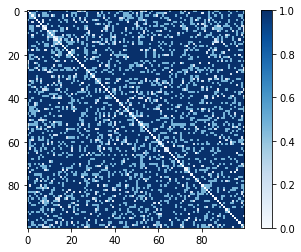

In [17]:
#to visualise the distance matrix where dissimilar elements are furthest while similar elements are nearer
plt.imshow(dist, zorder=2, cmap='Blues', interpolation='nearest')  
plt.colorbar();

Before performing clustering, multidimensional scaling (MDS) is performed to facilitate visualizing the level of similarity of individual elements in the dataset using a scatter plot.

(-0.8446202183834166,
 0.8568531405031793,
 -0.7908210365850312,
 0.7931668216971077)

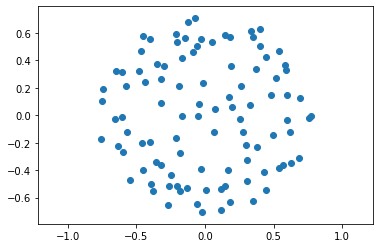

In [18]:
m = MDS(n_components=2, dissimilarity='precomputed', random_state=0)
out = m.fit_transform(dist)
plt.scatter(out[:,0],out[:,1])
plt.axis('equal')

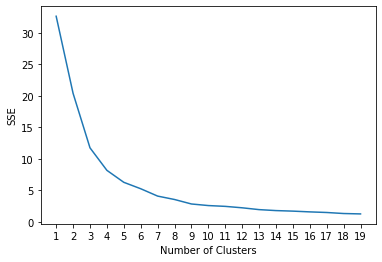

In [19]:
kmeans_kwargs = {"init": "random","n_init": 10,"max_iter": 300,"random_state": 0}
sse = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(out)
    sse.append(kmeans.inertia_)
plt.plot(range(1, 20), sse)
plt.xticks(range(1, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

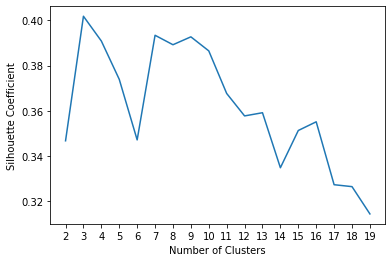

In [20]:
silhouette_coefficients = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(out)
    score = silhouette_score(out, kmeans.labels_)
    silhouette_coefficients.append(score)
plt.plot(range(2, 20), silhouette_coefficients)
plt.xticks(range(2, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

Based on the Elbow chart and Silhouette score, the ideal number of clusters should be 3, which is shown in the scatter plot below. 

(-0.8463797383849878,
 0.8586126605047505,
 -0.793530231289437,
 0.7958760164015135)

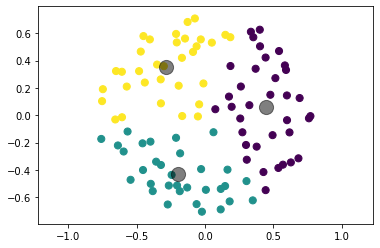

In [21]:
kmeans = KMeans(init="random",n_clusters=3,n_init=10,max_iter=300,random_state=0)
kmeans.fit(out)
y_kmeans = kmeans.predict(out)
plt.scatter(out[:, 0], out[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.axis('equal')

In [22]:
d = {k:v for k,v in zip(list(wordnet.index),list(kmeans.labels_))}
c0 = [k for k,v in d.items() if v==0]
c1 = [k for k,v in d.items() if v==1]
c2 = [k for k,v in d.items() if v==2]
print(f"Cluster 0: {c0} \n")
print(f"Cluster 1: {c1} \n")
print(f"Cluster 2: {c2} \n")

Cluster 0: ['based', 'better', 'brain', 'breakthrough', 'care', 'crowdsourcing', 'disease', 'effective', 'incentive', 'individual', 'innovative', 'innovator', 'internet', 'learning', 'make', 'maker', 'market', 'medicine', 'movement', 'number', 'open', 'opportunity', 'patient', 'policy', 'precision', 'record', 'resource', 'result', 'significant', 'social', 'software', 'success', 'treatment', 'way', 'work'] 

Cluster 1: ['address', 'budget', 'build', 'building', 'business', 'clean', 'commercial', 'company', 'department', 'education', 'employee', 'evidence', 'example', 'foundation', 'fund', 'funding', 'goal', 'grand', 'human', 'idea', 'includes', 'including', 'institute', 'many', 'mission', 'percent', 'scale', 'small', 'startup', 'student', 'time', 'university'] 

Cluster 2: ['accelerate', 'access', 'across', 'advance', 'application', 'area', 'best', 'collaboration', 'computing', 'connected', 'continue', 'deployment', 'develop', 'dramatically', 'driving', 'economic', 'economy', 'future', 

Description of above clusters

- Cluster 0 seems to include words related to medical (eg. brain, care, disease, medicine, patient, precision, social, treatment), outcome (eg. better, breakthrough, effective, innovative, make, result, success, work). 
- Cluster 1 seems to include words related to resources (eg. budget, fund, funding, time, idea, student), commercial (eg. business, commercial, startup), organisations (eg. department, institute, university) and execution (eg. goal, mission). 
- Cluster 2 seems to include words related to tech (eg. computing, hpc, scientific, smart, access), upward trend (eg. advance, continue, driving, growing, high), approach (eg. collaboration, connected, performance, priority, strategic, strategy). 


## Word Pairs 

Let's check the word pairs which have the most number of common neighbours. 

In [24]:
vectorizer1 = CountVectorizer()
matrix1 = vectorizer1.fit_transform(df['processed'])   #use CountVectorizer to obtain counts of top100 words in each sentence
wordnet1 = pd.DataFrame(matrix1.toarray(), index=df.index, columns=vectorizer1.get_feature_names())
wordnet1 = wordnet1.applymap(lambda x: int(1) if int(x)>0 else int(0))  #to address words that appear multiple times in same sentence
wordnet1 = wordnet1.T.dot(wordnet1)                 #to calculate the number of edges between two words
np.fill_diagonal(wordnet1.values, 0)              #to remove edge to the word itself
wordnet1

,ability,able,academia,academic,accelerate,accelerated,accelerates,accelerating,acceptance,access,...,working,workshop,world,would,yet,yield,york,young,youth,zero
ability,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
able,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
academia,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
academic,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
accelerate,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yield,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
york,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
young,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
youth,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
wordpair = wordnet1.dot(wordnet1)
np.fill_diagonal(wordpair.values, 0)  
wordpair = wordpair.where(np.triu(np.ones(wordpair.shape)).astype(np.bool))
wordpair = wordpair.stack().reset_index()
wordpair.columns = ['Word 1','Word 2','Value']
wordpair = wordpair.sort_values(by='Value', ascending=False).reset_index().drop(['index'],axis=1)
wordpair[:5]

,Word 1,Word 2,Value
0,collaboration,multi,138.0
1,best,practice,127.0
2,medicine,precision,119.0
3,disease,treatment,118.0
4,best,collaboration,116.0


Description of top 5 word pairs
- Word pair 0: Multi and collaboration come hand in hand as collaboration is required when multiple stakeholders are involved. Since innovation requires collaboration among multiple stakeholders, it is not surprising to see it as a top word pair. 
- Word pair 1: As part of innovation, better approaches do become best practices which help to improve the way things are done. 
- Word pair 2: Precision medicine is part of the innovative approach to target diseases. As such, it is not surprising to see it as one of the top word pairs. 
- Word pair 3: Disease and treatment are closely related, which could explain why it is one of the top word pairs. 
- Word pair 4: As precision medicine is an innovation in treatment of diseases, this could be why precision and treatment could be one of the top word pairs. 

## Topic Summarization Using Top Word Pairs

Let's try topic summrization using the top word pairs found. 

In [27]:
top100 = set()
i = 0
while len(top100)<100:
    top100.add(wordpair['Word 1'][i])
    top100.add(wordpair['Word 2'][i])
    i += 1
print(top100)

{'idea', 'school', 'edge', 'percent', 'world', 'job', 'together', 'intervention', 'engineering', 'volunteer', 'discovery', 'high', 'performance', 'team', 'education', 'best', 'build', 'key', 'addition', 'nasa', 'multi', 'example', 'already', 'work', 'improvement', 'crowdsourcing', 'hpc', 'advance', 'learning', 'better', 'white', 'software', 'worker', 'training', 'employee', 'scientific', 'across', 'small', 'test', 'collaboration', 'practice', 'benefit', 'including', 'priority', 'skilled', 'time', 'safety', 'medical', 'patient', 'economic', 'market', 'care', 'solution', 'pay', 'growth', 'company', 'house', 'department', 'social', 'ensure', 'university', 'precision', 'delivery', 'century', 'economy', 'individual', 'develop', 'skill', 'success', 'way', 'deployment', 'researcher', 'security', 'brain', 'based', 'per', 'partnership', 'include', 'st', 'human', 'accelerate', 'grant', 'funding', 'smart', 'fund', 'application', 'student', 'medicine', 'business', 'industry', 'two', 'disease', 'tr

In [28]:
d = {}
for n in range(0,i):
    if d.get(wordpair['Word 1'][n]) == None:
        d[wordpair['Word 1'][n]] = [wordpair['Word 2'][n]]
    else:
        d[wordpair['Word 1'][n]].extend([wordpair['Word 2'][n]])
    if d.get(wordpair['Word 2'][n]) == None:
        d[wordpair['Word 2'][n]] = [wordpair['Word 1'][n]]
    else:
        d[wordpair['Word 2'][n]].extend([wordpair['Word 1'][n]])
print(d)

{'collaboration': ['multi', 'best', 'smart', 'practice', 'industry', 'patient', 'across', 'safety', 'company', 'economic', 'including', 'partnership', 'quality', 'strategy', 'advance', 'discovery', 'key', 'develop', 'scientific', 'improvement', 'high', 'test'], 'multi': ['collaboration', 'across', 'economic', 'industry', 'smart', 'university'], 'best': ['practice', 'collaboration', 'patient', 'develop', 'work', 'evidence', 'quality', 'small', 'high', 'partnership', 'improvement'], 'practice': ['best', 'collaboration', 'patient', 'partnership', 'improvement', 'quality', 'develop', 'evidence'], 'medicine': ['precision', 'treatment', 'advance', 'disease', 'individual'], 'precision': ['medicine', 'treatment', 'advance', 'disease', 'individual', 'discovery'], 'disease': ['treatment', 'brain', 'precision', 'researcher', 'medicine'], 'treatment': ['disease', 'precision', 'medicine', 'patient'], 'smart': ['collaboration', 'multi'], 'learning': ['software', 'student', 'educational', 'company', 

In [29]:
list(d.keys())

df["wordpair"] = df["processed"].apply(lambda x: ' '.join([x for x in x.split() if x in list(d.keys())]))
df["wordpaircount"] = df["wordpair"].apply(lambda x: len(str(x).split()))

#Use sentences that contain more than 8 of the top 100 frequent words to summarize
summary1 = ' '.join(list(df[df['wordpaircount'] > 8]['original']))
summary1

'Agencies including the Department of Health and Human Services (HHS), NASA, the Department of the Interior (DOI), the Department of Agriculture (USDA), the Department of Homeland Security (DHS), DOE, and the Environmental Protection Agency (EPA) have established strategies and policies to accelerate widespread use of the new prizes and challenges. For example, after analyzing 338 citizen science biodiversity projects around the world, researchers at the University of Washington estimated that the in-kind contributions of 1.32.3 million citizen science volunteers to biodiversity research have an economic value of up to $2.5 billion per year.33 Other benefits include providing hands-on learning in science, technology, engineering, and mathematics (STEM), and connecting members of the public directly to Federal agency missions and to each other. bring together companies, Federal agencies, universities, and others to develop key advanced manufacturing technologies, help businesses develop

This approach of summarization has managed to select sentences from major sections across the given text, such as industries of the future, advanced manufacturing and inclusive innovation economy. As such, using ranking of word pairs has allowed the summarization to be more balanced.  

In addition, most of the selected sentences are from the respective "the Path Forward" sections for the various issues, which is useful since the next steps are usually the focus. 